### Here we're comparing retro results from different retro tools using LLMs.

In [9]:
aizynth = 'data/outputs/2025-06-14_125025'
reaxys = 'data/outputs/2025-06-19_191257'
synthia = 'data/outputs/2025-07-12_000332'

In [10]:
# Load routes

import os
import json

data_root = "../"

def get_all_scores(path):
    all_scores = {}
    for f in os.listdir(os.path.join(data_root, path)):
        with open(os.path.join(data_root, path, f)) as file:
            data = json.load(file)
        all_scores[f] = [float(data[i]['lmdata']['routescore']) for i in range(len(data))]

    return all_scores

In [11]:
target_map = {
    'dfc8116ec63329c437281f7a40dda876.json': "t1",
    '6137420e765c02d74671c89ca569ce41.json': "t4",
    '1823f3241b82133bbca85d6576cbed65.json': "t2",
    'ca06156bee8f14dcf0bd7e14f68eddcc.json': "t1",
    '1002fe2d610a74e4478530e12ab930e3.json': "t3",
    'ea8df340d54596eda93e23f04dff3a9b.json': "t4",
    '564d6fbe8d4540931e8a93ef36c895e2.json': "t4",
    '46f06d1a1e359b3230cfc1b81473a474.json': "t3",
    '4bfe366ec7f5d64678d500f9084cbb35.json': "t4",
    'e579d80f176371344bab95ea15e6b9ab.json': "t2",
    '280b79ef56e06a8af1a7d6b72c52148d.json': "t2",
    'b7593440c612f17a7201aef6d6667d0b.json': "t1",
    '00813afd159c009f6a6c9bf1207b07f4.json': "t4",

    'bf6e6641ffc7bf54d328bdb1568e1787.json': "t3",
    '0c0ea36bcefee71d4956cfc21454fe12.json': "t1",
}

In [12]:
# See how many are above a certain threshold per task (percent)

aiz_scores = get_all_scores(aizynth)
rxs_scores = get_all_scores(reaxys)
syn_scores = get_all_scores(synthia)

import pandas as pd

def get_results(perc):
    aiz_percents = {task:perc(scs) for task, scs in aiz_scores.items()}
    syn_percents = {task:perc(scs) for task, scs in syn_scores.items()}
    rxs_percents = {task:perc(scs) for task, scs in rxs_scores.items()}

    # Convert into DF
    aiz_df = pd.DataFrame.from_dict(aiz_percents, orient='index', columns=['AIZynth'])
    syn_df = pd.DataFrame.from_dict(syn_percents, orient='index', columns=['Synthia'])
    rxs_df = pd.DataFrame.from_dict(rxs_percents, orient='index', columns=['Reaxys'])

    # Merge the 3 datasets
    merged_df = pd.concat([aiz_df,rxs_df, syn_df], axis=1)

    merged_df.index.name = 'Task'
    merged_df['Target'] = merged_df.index.map(target_map)

    merged_df.sort_values(by='Target', inplace=True)
    return merged_df


from functools import partial

def perc(scs,tsh=5):
    return len([s for s in scs if s == tsh]) / len(scs) # * 100

func = partial(perc, tsh=7)
mdf = get_results(func)
mdf


,AIZynth,Reaxys,Synthia,Target
Task,,,,
dfc8116ec63329c437281f7a40dda876.json,0.066667,0.000000,NaN,t1
ca06156bee8f14dcf0bd7e14f68eddcc.json,0.083333,0.000000,NaN,t1
b7593440c612f17a7201aef6d6667d0b.json,0.050000,0.000000,NaN,t1
0c0ea36bcefee71d4956cfc21454fe12.json,NaN,NaN,0.08,t1
1823f3241b82133bbca85d6576cbed65.json,0.000000,0.000000,NaN,t2
e579d80f176371344bab95ea15e6b9ab.json,0.000000,0.000000,NaN,t2
280b79ef56e06a8af1a7d6b72c52148d.json,0.000000,0.000000,0.00,t2
1002fe2d610a74e4478530e12ab930e3.json,0.000000,0.083333,NaN,t3
46f06d1a1e359b3230cfc1b81473a474.json,0.000000,0.000000,NaN,t3


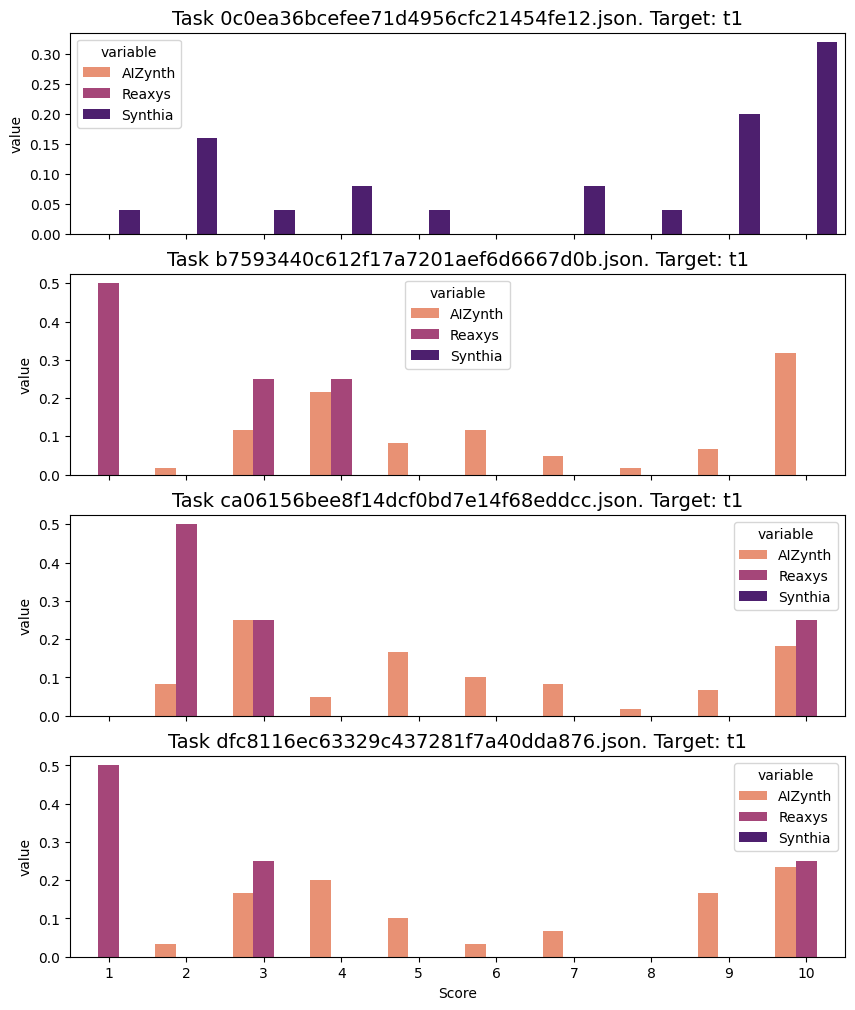

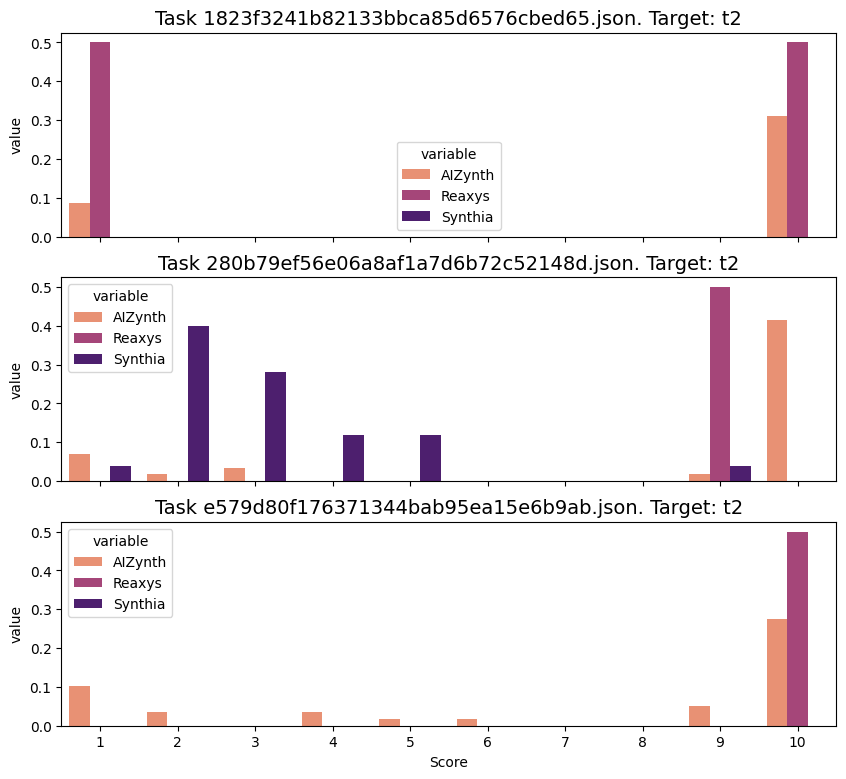

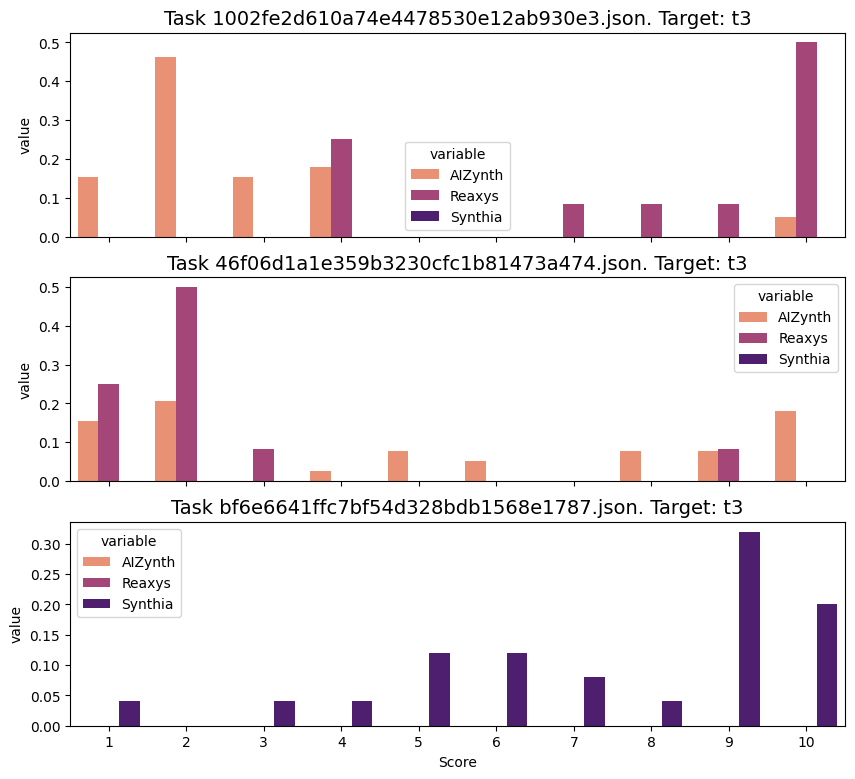

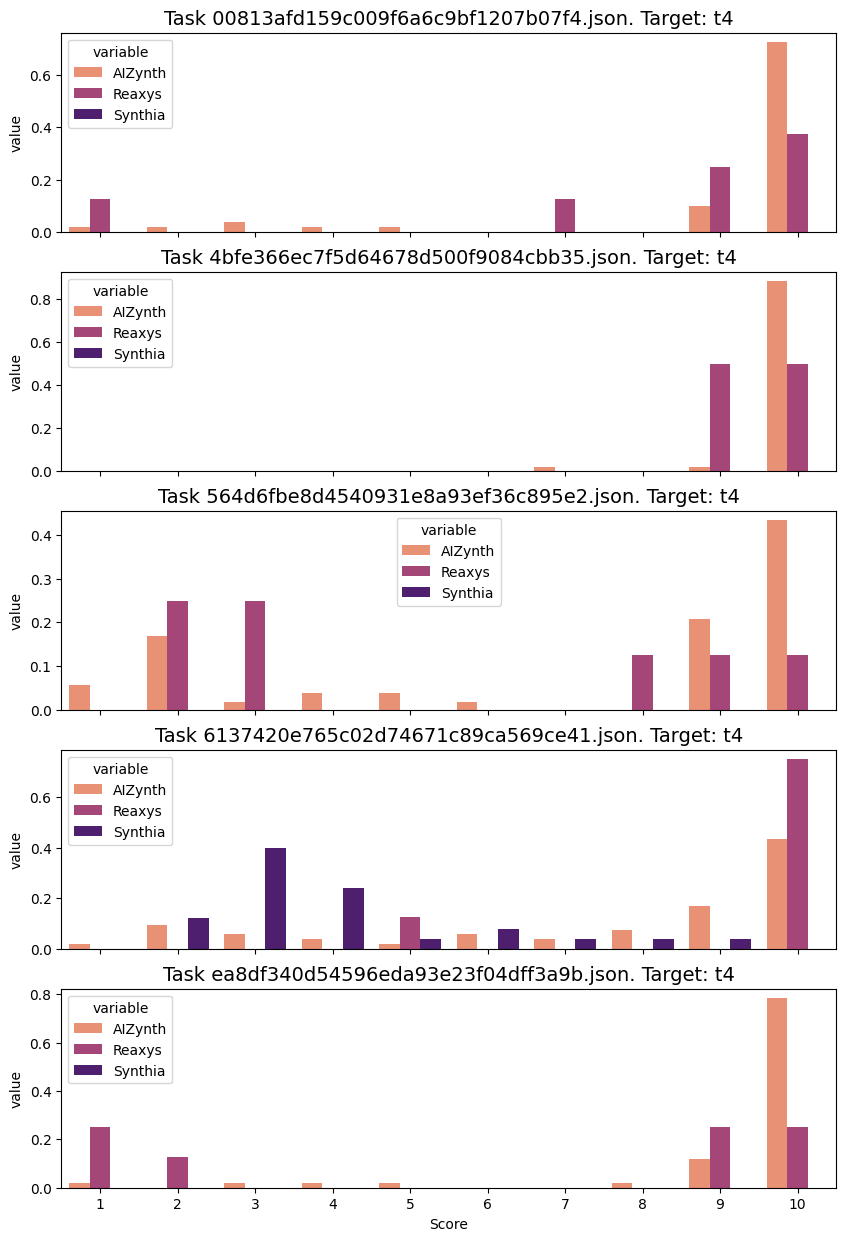

In [13]:
def perc(scs,tsh=5):
    return len([s for s in scs if s == tsh]) / len(scs) #* 100

dfs = []
for i in range(1,11):
    func = partial(perc, tsh=i)
    mdf = get_results(func)
    mdf['Score'] = i
    dfs.append(mdf)

df = pd.concat(dfs).reset_index()

import matplotlib.pyplot as plt
import seaborn as sns


grp_target = df.groupby('Target')
for tgt, gtarg in grp_target:
    fig, ax = plt.subplots(gtarg.Task.nunique(), figsize=(10, 3*gtarg.Task.nunique()), sharex=True, gridspec_kw={'hspace': 0.2})
    grp = gtarg.groupby('Task')

    for j, (i, g) in enumerate(grp):
        title = f"Task {i}. Target: {target_map[i]}"
        ax[j].set_title(title, fontsize=14)
        dg = g.reset_index().melt(
            id_vars=['Score'],
            value_vars=['AIZynth', 'Reaxys', 'Synthia'],
        )

        sns.barplot(
            data=dg,
            x='Score',
            y='value',
            hue='variable',
            palette='magma_r',
            ax=ax[j],
            err_kws={
                'linewidth': 0.8,
                'color': 'k',
                'alpha': 1,
                # 'capthick': 1,
                # 'elinewidth': 1
            },
            capsize= 0.1,
        )
    plt.show()

    fig.savefig(f'{tgt}_per_tool.svg', bbox_inches='tight')

# Feasibility

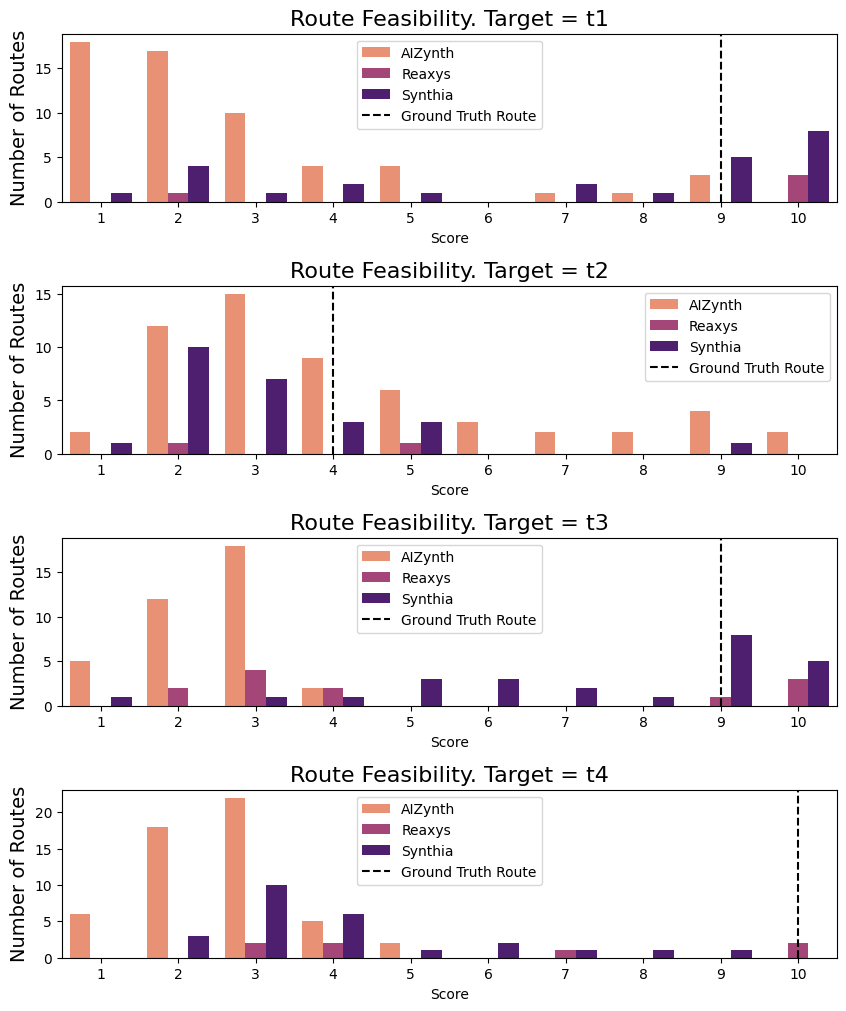

In [14]:
# synthia = "data/outputs/2025-06-19_203002"
synthia = "data/outputs/2025-07-12_000332"
# reaxys = "data/outputs/2025-06-19_205206"
reaxys = "data/outputs/2025-06-19_203104"
aizynth = "data/outputs/2025-06-19_212237"

syn_scores = get_all_scores(synthia)


fig, ax = plt.subplots(4,1,figsize=(10, 12), gridspec_kw={'hspace': 0.5})

tgts= ['0c0ea36bcefee71d4956cfc21454fe12.json', '280b79ef56e06a8af1a7d6b72c52148d.json', 'bf6e6641ffc7bf54d328bdb1568e1787.json', '6137420e765c02d74671c89ca569ce41.json', ]
gtrte_scores = [9, 4, 9, 10]

for j, key in enumerate(tgts):
    tgt = target_map[key]

    aiz_scores = {key: get_all_scores(aizynth).get(key, {})}
    rxs_scores = {key: get_all_scores(reaxys)[key]}
    syn_scores = {key: get_all_scores(synthia)[key]}
    
    def perc(scs,tsh=5):
        return len([s for s in scs if s == tsh])# / len(scs) * 100

    dfs = []
    for i in range(1,11):
        func = partial(perc, tsh=i)
        mdf = get_results(func)
        mdf['Score'] = i
        dfs.append(mdf)

    df = pd.concat(dfs)

    import matplotlib.pyplot as plt
    import seaborn as sns


    sns.barplot(
        data=df.reset_index().melt(
            id_vars=['Task', 'Score'],
            value_vars=['AIZynth', 'Reaxys', 'Synthia'],
        ),
        x='Score',
        y='value',
        hue='variable',
        palette='magma_r',
        ax=ax[j],
        err_kws={
            'linewidth': 0.8,
            'color': 'k',
            'alpha': 1,
            # 'capthick': 1,
            # 'elinewidth': 1
        },
        capsize= 0.1,
    )

    if gtrte_scores[j] is not None:
        ax[j].axvline(gtrte_scores[j]-1, color='k', linestyle='--', label='Ground Truth Route')
        ax[j].legend()
        
    ax[j].set_title(f'Route Feasibility. Target = {tgt}', fontsize=16)
    ax[j].set_ylabel('Number of Routes', fontsize=14)

fig.savefig('route_feasibility_per_target.svg', bbox_inches='tight')

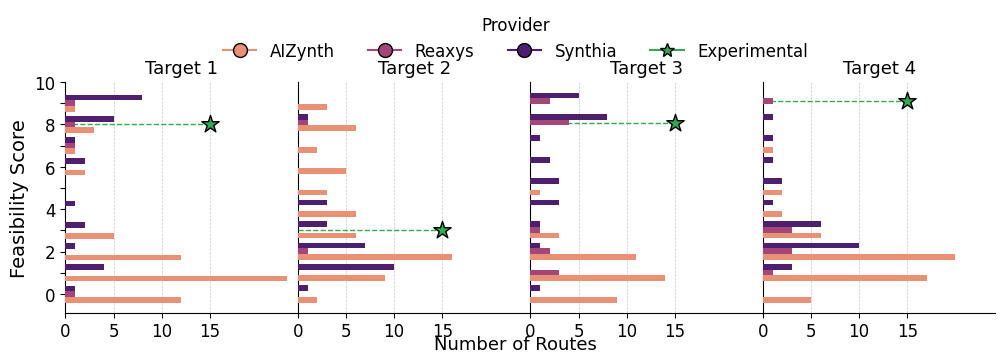

In [17]:

synthia = "data/outputs/2025-07-12_005613"
reaxys = "data/outputs/2025-07-12_004754"
aizynth = "data/outputs/2025-06-25_094254"

syn_scores = get_all_scores(synthia)


fig, ax = plt.subplots(1,4,figsize=(12, 3), gridspec_kw={'hspace': 0., 'wspace': 0.}, sharex=True)

tgts= ['0c0ea36bcefee71d4956cfc21454fe12.json', '280b79ef56e06a8af1a7d6b72c52148d.json', 'bf6e6641ffc7bf54d328bdb1568e1787.json', '6137420e765c02d74671c89ca569ce41.json', ]
gtrte_scores = [9, 4, 9, 10]

for j, key in enumerate(tgts):
    tgt = target_map[key]

    aiz_scores = {key: get_all_scores(aizynth).get(key, {})}
    rxs_scores = {key: get_all_scores(reaxys)[key]}
    syn_scores = {key: get_all_scores(synthia)[key]}
    
    def perc(scs,tsh=5):
        return len([s for s in scs if s == tsh])# / len(scs) * 100

    dfs = []
    for i in range(1,11):
        func = partial(perc, tsh=i)
        mdf = get_results(func)
        mdf['Score'] = i
        dfs.append(mdf)

    df = pd.concat(dfs)

    import matplotlib.pyplot as plt
    import seaborn as sns
    import matplotlib.lines as mlines  # <-- Import 'lines' for creating legend handles


    sns.barplot(
        data=df.reset_index().melt(
            id_vars=['Task', 'Score'],
            value_vars=['AIZynth', 'Reaxys', 'Synthia'],
        ),
        y='Score',
        x='value',
        hue='variable',
        palette='magma_r',
        ax=ax[j],
        err_kws={
            'linewidth': 0.8,
            'color': 'k',
            'alpha': 1,
            # 'capthick': 1,
            # 'elinewidth': 1
        },
        orient='h',
        capsize= 0.1,
        legend=False,
        zorder=10
    )

    # if gtrte_scores[j] is not None:
        # ax[j].axhline(gtrte_scores[j]-1, color='k', linestyle='--', label='Ground Truth Route')
        # ax[j].legend()
        
    ax[j].set_title(f'Target {tgt.strip("t")}', fontsize=13)
    ax[j].set_xlabel('')
    if j == 0:
        ax[j].set_ylabel('Feasibility Score', fontsize=14)
    else:
        ax[j].set_ylabel('', fontsize=14)
        ax[j].set_yticks([])
        ax[j].set_yticklabels([])

    ax[j].grid(True, axis='x', which='both', linestyle='--', linewidth=0.5, alpha=0.7, zorder=0)


    # Now for each plot, add a star wherever the score should be
    if gtrte_scores[j] is not None:
        ax[j].scatter(
            15, gtrte_scores[j]-1,
            color='#34A853', 
            marker='*',
            edgecolor='black',
            s=170, 
            label='Ground Truth Route',
            zorder=11
        )
        # add a line from 0 to the star
        ax[j].plot(
            [0, 15], [gtrte_scores[j]-1, gtrte_scores[j]-1],
            color='#34A853', 
            linestyle='--', 
            linewidth=1,
            zorder=9
        )

        # make xticklabels larger font
        ax[j].set_xticks([0, 5, 10, 15])
        ax[j].set_xticklabels(ax[j].get_xticks(), fontsize=12)
        if j==0:
            ax[j].set_yticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
            ax[j].set_yticklabels([0, '', 2, '', 4, '', 6, '', 8, '', 10], fontsize=12)

# Add super title
# fig.suptitle('Route Feasibility per Target', fontsize=18, y=1.04)
# Gloabl xlabel
fig.text(
    0.5, -0.01, 'Number of Routes', ha='center', fontsize=13
)

sty = pd.DataFrame({
    "AIZynth": {"color": "#E89174", "provider": "AIZynth", "marker": "o"},
    "Reaxys": {"color": "#A54679", "provider": "Reaxys", "marker": "o"},
    "Synthia": {"color": "#4D1F6E", "provider": "Synthia", "marker": "o"},
    "Experimental": {"color": "#34A853", "provider": "Experimental", "marker": "*"}
}).T

# Create a list of "proxy artists" for the legend
legend_handles = [
    mlines.Line2D(
        [], [], # No data
        color=row['color'],
        marker=row['marker'],
        markeredgecolor='black', # Edge color for visibility
        markersize=10,
        label=row['provider']
    ) for index, row in sty.iterrows()
]

# Place the legend at the bottom of the plot
fig.legend(
    handles=legend_handles,
    title='Provider',
    title_fontsize='12',
    loc='upper center', # Location relative to the bbox_to_anchor
    bbox_to_anchor=(0.5, 1.15), # Position legend below the plot (0.5=center, -0.1=just below)
    ncol=4, # Number of columns in the legend
    frameon=False, # Remove the legend box frame
    fontsize='12'
)

# invert y axis
for a in ax:
    a.invert_yaxis()
sns.despine()



fig.savefig('route_feasibility_per_target.svg', bbox_inches='tight')

In [8]:
# Lets get the top routes for each target
import numpy as np

syn_scores = get_all_scores(synthia)
aiz_scores = get_all_scores(aizynth)
rxs_scores = get_all_scores(reaxys)


def get_top_routes(scores, name, top_n=5):
    dfs = []
    best = pd.Series(scores).sort_values(ascending=False).head(top_n)
    wors = pd.Series(scores).sort_values(ascending=True).head(top_n).sort_values(ascending=False)

    d = pd.concat([best, wors], axis=0).rename('score').reset_index()
    d['target'] = target_map[key]
    d['source'] = name
    dfs.append(d)

    idxs = pd.concat(dfs, ignore_index=True)['index']
    return idxs


def select_routes(path, top_n=2):
    all_routes = []
    for f in os.listdir(os.path.join(data_root, path)):
        with open(os.path.join(data_root, path, f)) as file:
            data = json.load(file)
        scores = [float(data[i]['lmdata']['routescore']) for i in range(len(data))]
        idxs = get_top_routes(scores, name=path, top_n=2)
        routes = [data[j] for i,j in idxs.iteritems()]
        all_routes.extend(routes)

    return all_routes

rtess = select_routes(aizynth)
to_dir = "data/outputs/top_feasible/"
with open(os.path.join(data_root, to_dir, 'top_routes_aizynth.json'), 'w') as f:
    json.dump(rtess, f, indent=2)

rtess = select_routes(synthia)
with open(os.path.join(data_root, to_dir, 'top_routes_synthia.json'), 'w') as f:
    json.dump(rtess, f, indent=2)

rtess = select_routes(reaxys)
with open(os.path.join(data_root, to_dir, 'top_routes_reaxys.json'), 'w') as f:
    json.dump(rtess, f, indent=2)

/tmp/ipykernel_4192621/1111179860.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  routes = [data[j] for i,j in idxs.iteritems()]
/tmp/ipykernel_4192621/1111179860.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  routes = [data[j] for i,j in idxs.iteritems()]
/tmp/ipykernel_4192621/1111179860.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  routes = [data[j] for i,j in idxs.iteritems()]
/tmp/ipykernel_4192621/1111179860.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  routes = [data[j] for i,j in idxs.iteritems()]
/tmp/ipykernel_4192621/1111179860.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  routes = [data[j] for i,j in idxs.iteritems()]
/tmp/ipykernel_4192621/1111179860.py:30: FutureWar